# Data preparation

In [15]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import rasterio
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp

from model import SolarModel
from data_gen import get_training_augmentation, get_validation_augmentation, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

Helper Functions

In [2]:
# Data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()
    

In [3]:
CAL_DATA_DIR = "/home/as1233/cape_town_segmentation/data/cal_320"
# CP_DATA_DIR = "/home/as1233/data/cape_town"

cal_x_train_dir = os.path.join(CAL_DATA_DIR, 'train/images')
cal_y_train_dir = os.path.join(CAL_DATA_DIR, 'train/masks')

cal_x_valid_dir = os.path.join(CAL_DATA_DIR, 'val/images')
cal_y_valid_dir = os.path.join(CAL_DATA_DIR, 'val/masks')

cal_x_test_dir = os.path.join(CAL_DATA_DIR, 'test/images')
cal_y_test_dir = os.path.join(CAL_DATA_DIR, 'test/masks')

cal_tile_size = 320

# cp_x_train_dir = os.path.join(CP_DATA_DIR, 'train/images')
# cp_y_train_dir = os.path.join(CP_DATA_DIR, 'train/masks')

# cp_x_valid_dir = os.path.join(CP_DATA_DIR, 'val/images')
# cp_y_valid_dir = os.path.join(CP_DATA_DIR, 'val/masks')

# cp_x_test_dir = os.path.join(CP_DATA_DIR, 'test/images')
# cp_y_test_dir = os.path.join(CP_DATA_DIR, 'test/masks')

# cp_tile_size = 896

Let's visualize the california dataset

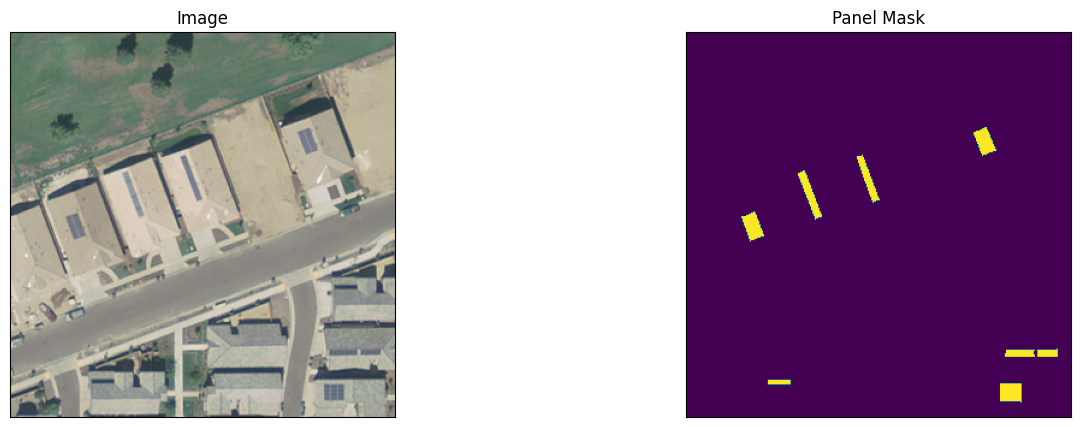

In [4]:
cal_dataset = Dataset(cal_x_train_dir, cal_y_train_dir, classes=["panel"])
# get some sample
image, mask = cal_dataset[0]
visualize(
    image=image,
    panel_mask=mask.squeeze(),
)

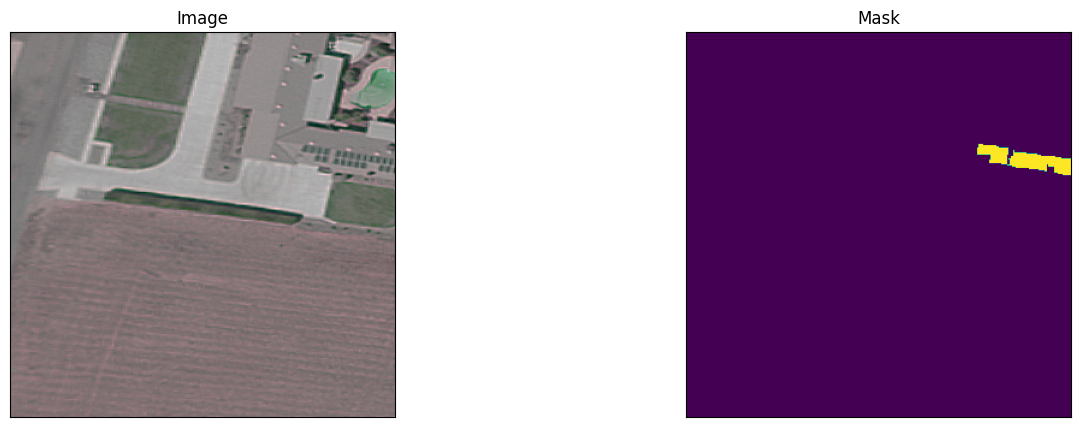

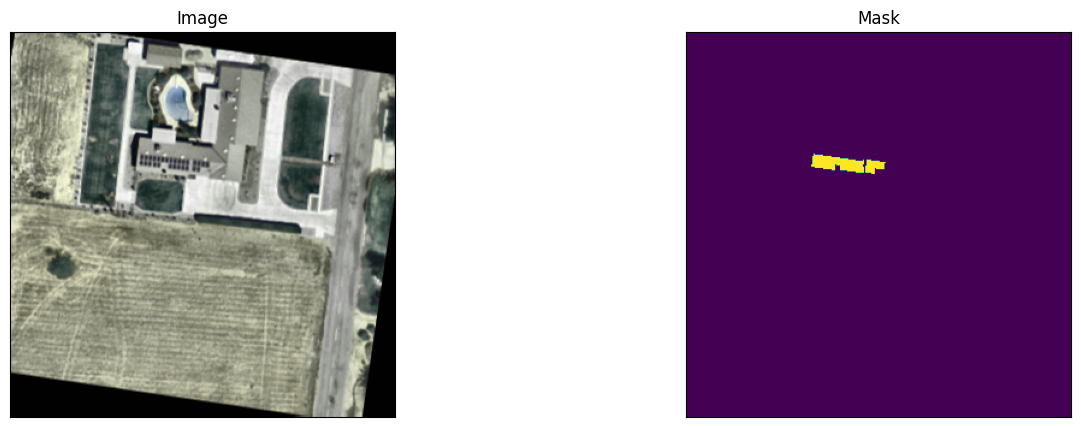

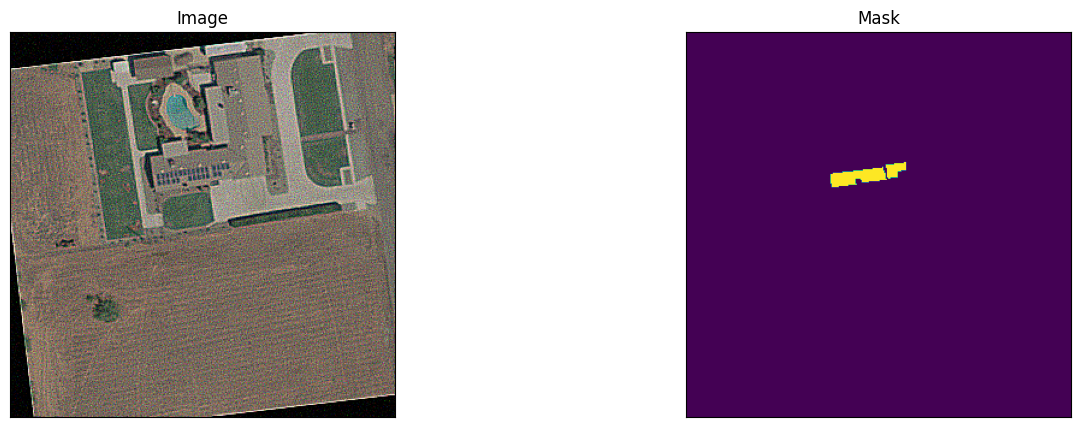

In [11]:
# Visualize resulted augmented images and masks
cal_augmented_dataset = Dataset(
    cal_x_train_dir,
    cal_y_train_dir,
    augmentation=get_training_augmentation(cal_tile_size),
    classes=["panel"],
)

# visualize same image with different random transforms
for i in range(3):
    image, mask = cal_augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

Let's visualize the cape town dataset

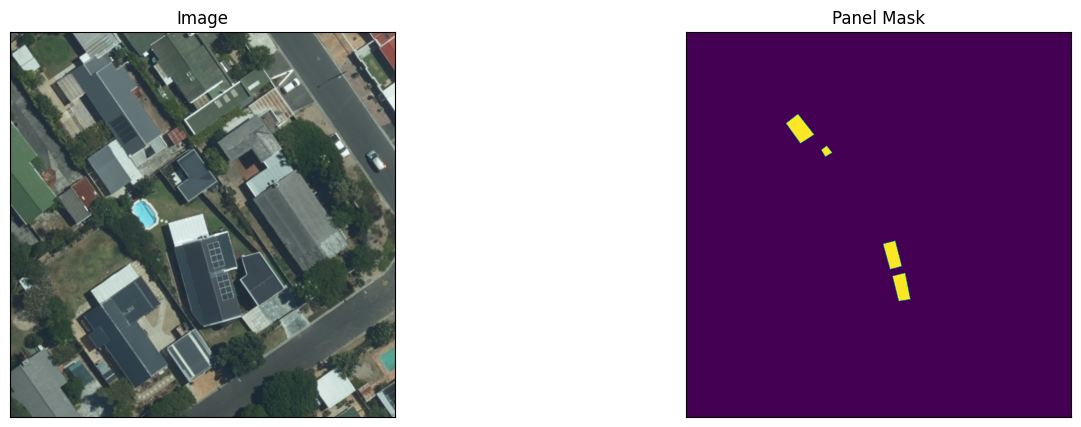

In [4]:
# cp_dataset = Dataset(cp_x_train_dir, cp_y_train_dir, classes=["panel"])
# # get some sample
# image, mask = cp_dataset[10]
# visualize(
#     image=image,
#     panel_mask=mask.squeeze(),
# )

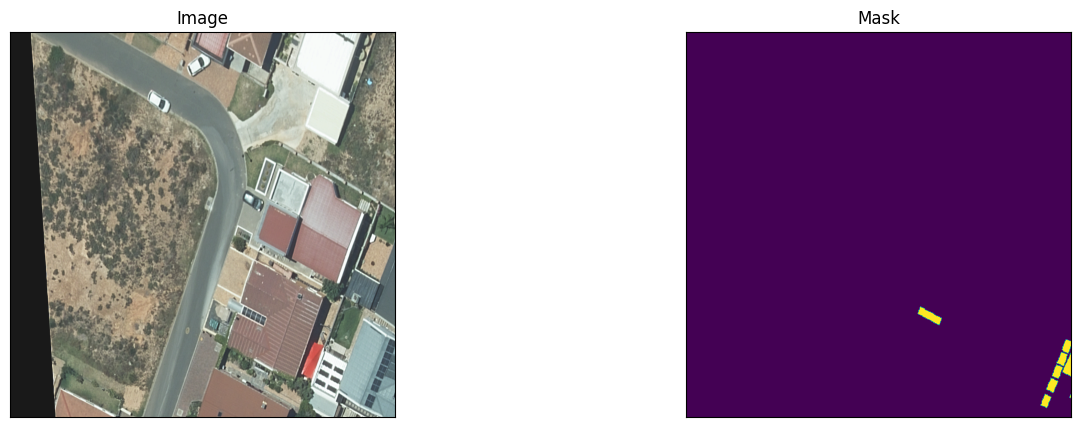

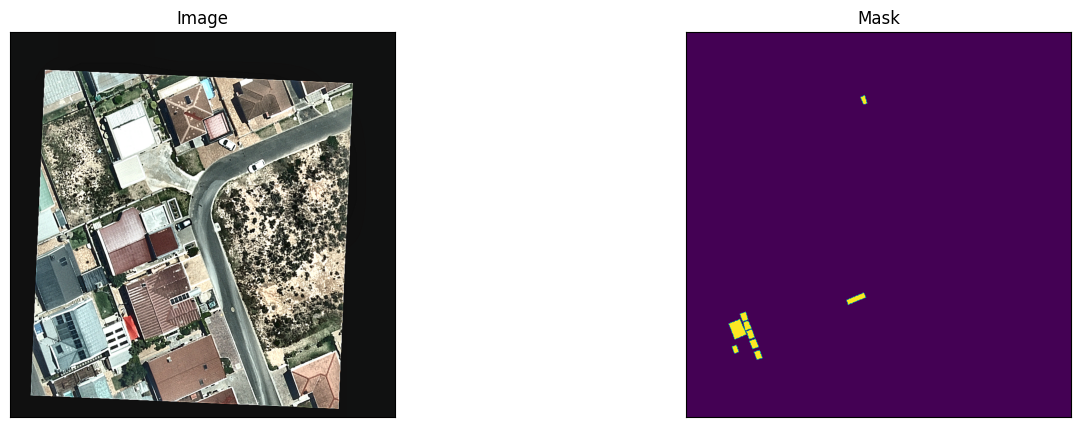

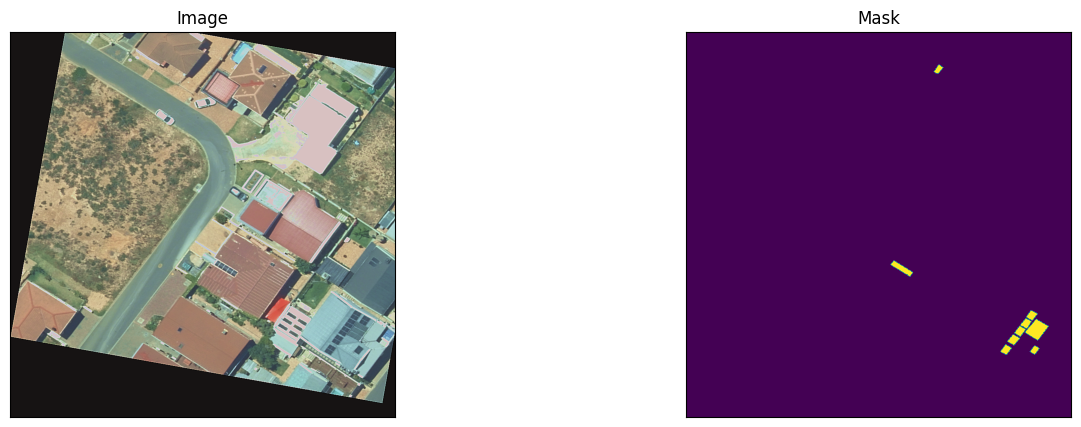

In [5]:
# # Visualize resulted augmented images and masks
# cp_augmented_dataset = Dataset(
#     cp_x_train_dir,
#     cp_y_train_dir,
#     augmentation=get_training_augmentation(cp_tile_size),
#     classes=["panel"],
# )

# # visualize same image with different random transforms
# for i in range(3):
#     image, mask = cp_augmented_dataset[3]
#     visualize(image=image, mask=mask.squeeze())

# Training

## Training with California dataset

In [4]:
CLASSES = ["solar_panel"]

cal_train_dataset = Dataset(
    cal_x_train_dir,
    cal_y_train_dir,
    augmentation=get_training_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_valid_dataset = Dataset(
    cal_x_valid_dir,
    cal_y_valid_dir,
    augmentation=get_validation_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_test_dataset = Dataset(
    cal_x_test_dir,
    cal_y_test_dir,
    augmentation=get_validation_augmentation(cal_tile_size),
    classes=CLASSES,
)

cal_train_loader = DataLoader(cal_train_dataset, batch_size=32, shuffle=True, num_workers=4)
cal_valid_loader = DataLoader(cal_valid_dataset, batch_size=32, shuffle=False, num_workers=4)
cal_test_loader = DataLoader(cal_test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
EPOCHS = 40
T_MAX = EPOCHS * len(cal_train_loader) # pay attention to len here when you train with the cape town dataset
OUT_CLASSES = 1

In [6]:
model = SolarModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES, T_max=T_MAX)

In [7]:
checkpoint_callback = ModelCheckpoint(
    dirpath='/home/as1233/cape_town_segmentation/trained_models/cal_320',   
    filename='{epoch}-{valid_dataset_iou:.4f}',  
    monitor='valid_dataset_iou',                
    save_top_k=-1, # save all checkpoints             
    mode='min',                         
)

In [8]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback]  
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:


trainer.fit(
    model,
    train_dataloaders=cal_train_loader,
    val_dataloaders=cal_valid_loader,
)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-02-04 08:43:17.802579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 08:43:17.838298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the approp

Epoch 39: 100%|██████████| 426/426 [03:09<00:00,  2.25it/s, v_num=0, valid_per_image_iou=0.925, valid_dataset_iou=0.929, train_per_image_iou=0.874, train_dataset_iou=0.881]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 426/426 [03:10<00:00,  2.24it/s, v_num=0, valid_per_image_iou=0.925, valid_dataset_iou=0.929, train_per_image_iou=0.874, train_dataset_iou=0.881]


In [ ]:
# model = SolarModel.load_from_checkpoint(
#     checkpoint_path="/home/as1233/SolarDetection/trained_models/SolarModel/solar_model_checkpoint_124.ckpt/",
#     arch='FPN',
#     encoder_name='resnext50_32x4d',
#     in_channels=3,
#     out_classes=OUT_CLASSES,
# )

# model.eval()  

FileNotFoundError: [Errno 2] No such file or directory: '/home/as1233/SolarDetection/trained_models/SolarModel/solar_model_checkpoint_124.ckpt'

In [ ]:
model.eval()

valid_metrics = trainer.validate(model, dataloaders=cal_valid_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 92/92 [00:02<00:00, 30.87it/s]
[{'valid_per_image_iou': 0.8913792371749878, 'valid_dataset_iou': 0.8954570889472961}]


In [14]:
# run test dataset

test_metrics = trainer.test(model, dataloaders=cal_test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 92/92 [00:29<00:00,  3.07it/s]
[{'test_per_image_iou': 0.8911635875701904, 'test_dataset_iou': 0.8945603966712952}]


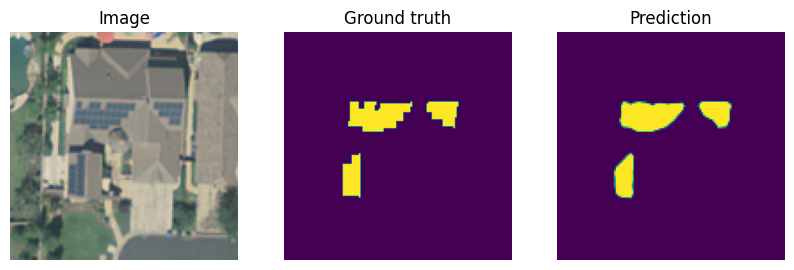

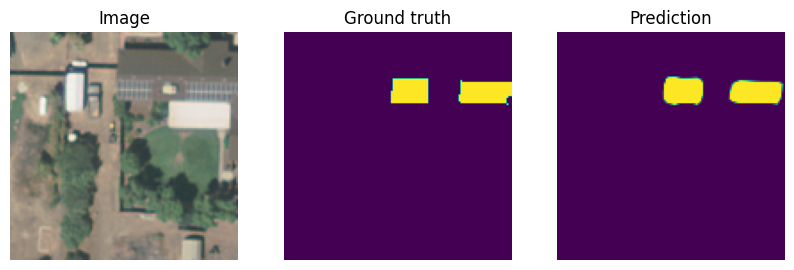

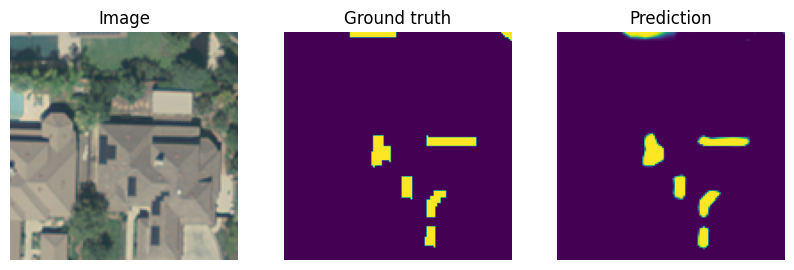

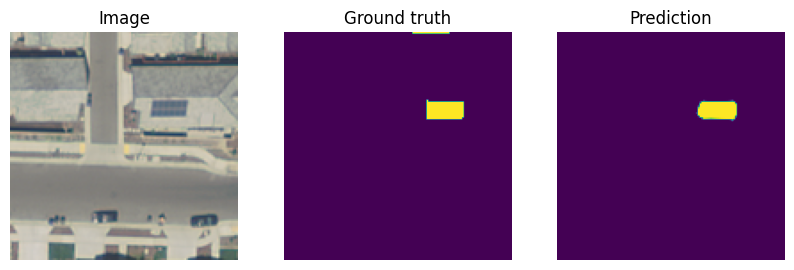

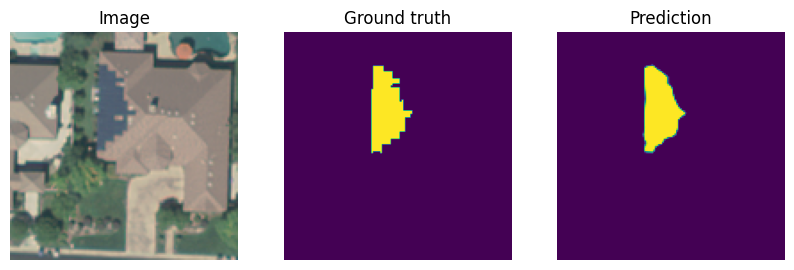

In [18]:
images, masks = next(iter(cal_test_loader))
with torch.no_grad():
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

In [10]:
# cp_train_dataset = Dataset(
#     cp_x_train_dir,
#     cp_y_train_dir,
#     augmentation=get_training_augmentation(cp_tile_size),
#     classes=CLASSES,
# )



# cp_valid_dataset = Dataset(
#     cp_x_valid_dir,
#     cp_y_valid_dir,
#     augmentation=get_validation_augmentation(cp_tile_size),
#     classes=CLASSES,
# )

# cp_test_dataset = Dataset(
#     cp_x_test_dir,
#     cp_y_test_dir,
#     augmentation=get_validation_augmentation(cp_tile_size),
#     classes=CLASSES,
# )

# cp_train_loader = DataLoader(cp_train_dataset, batch_size=32, shuffle=True, num_workers=4)
# cp_valid_loader = DataLoader(cp_valid_dataset, batch_size=32, shuffle=False, num_workers=4)
# cp_test_loader = DataLoader(cp_test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [21]:
# Let's see how the trained model with the california dataset performs on the cape town one 
test_metrics = trainer.test(model, dataloaders=cp_test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]
[{'test_per_image_iou': 0.21968697011470795, 'test_dataset_iou': 0.2871120572090149}]


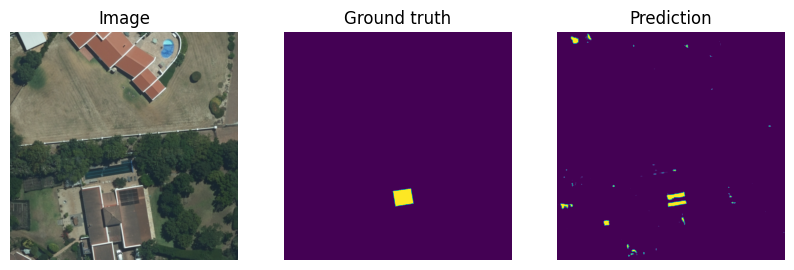

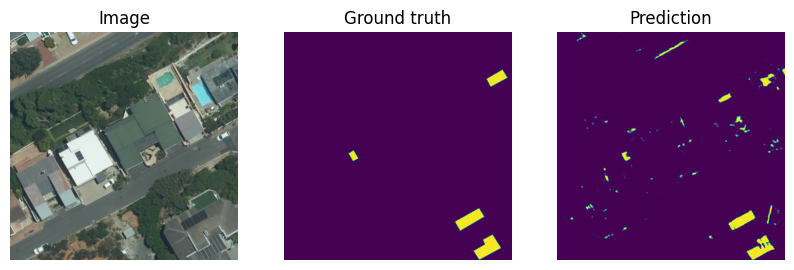

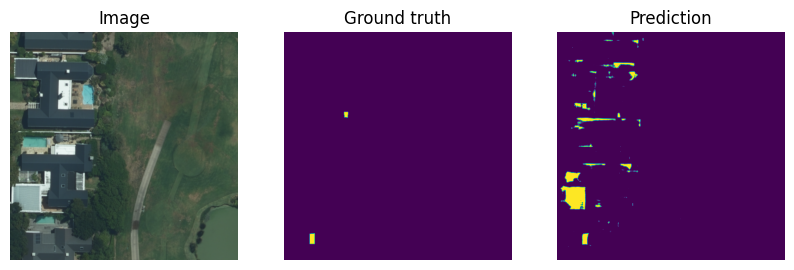

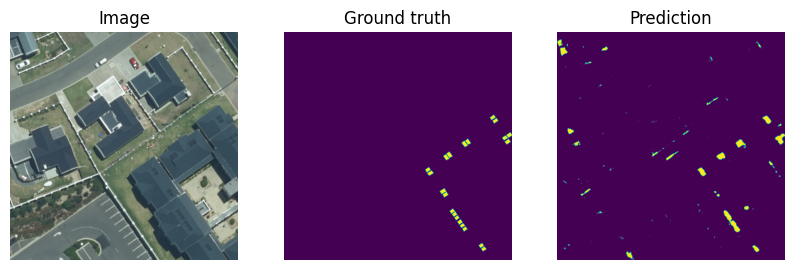

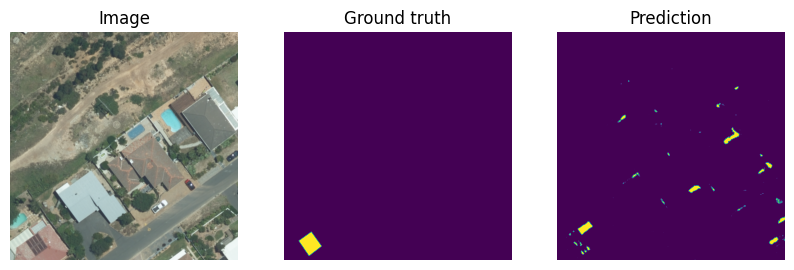

In [22]:
images, masks = next(iter(cp_test_loader))
with torch.no_grad():
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

## Fine tuning on the Cape Town dataset

The results are not so good. We need to fine tune the model on the cape town dataset.

In [ ]:
EPOCHS = 20
T_MAX = EPOCHS * len(cp_train_loader)
OUT_CLASSES = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fine_tuned_model = SolarModel.load_from_checkpoint(
    checkpoint_path="/home/as1233/SolarDetection/trained_models/solar_model_checkpoint_124_fine_tuned/epoch=0-val_loss=0.00-v2.ckpt",
    arch='FPN',
    encoder_name='resnext50_32x4d',
    in_channels=3,
    out_classes=OUT_CLASSES,
    T_max=T_MAX
)
fine_tuned_model.to(device)
fine_tuned_model.eval()

SolarModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

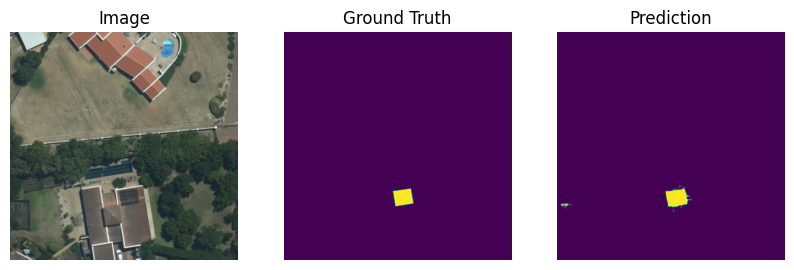

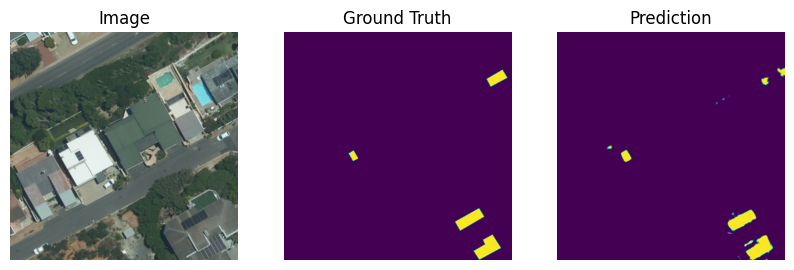

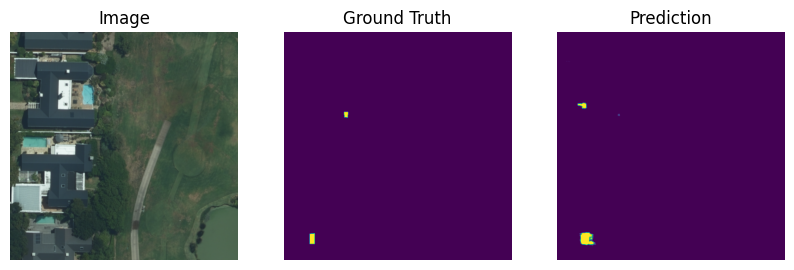

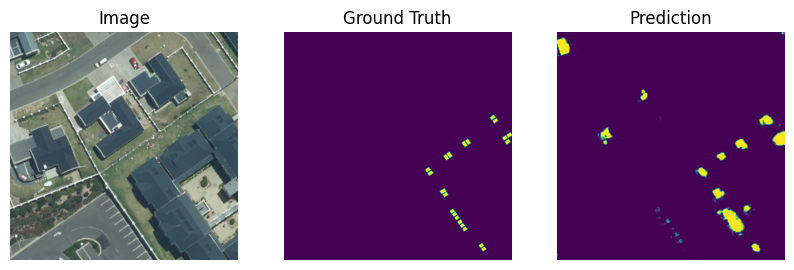

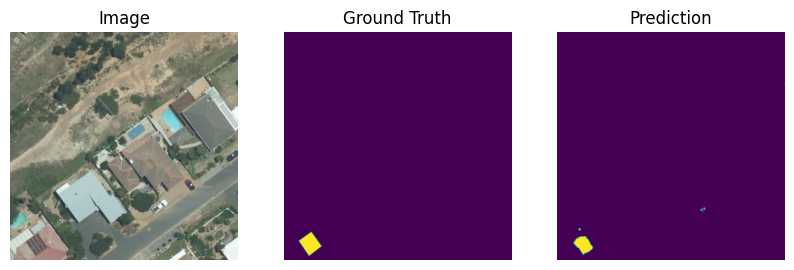

In [14]:
images, masks = next(iter(cp_test_loader))
images = images.to(device)
masks = masks.to(device)

with torch.no_grad():
    logits = fine_tuned_model(images)

pr_masks = logits.sigmoid().cpu()  

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images.cpu(), masks.cpu(), pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))  
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy().squeeze())  
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())  
        plt.title("Prediction")
        plt.axis("off")


In [12]:
log_path = '/home/as1233/SolarDetection/logs/solar_model_training/version_1/metrics.csv'  

log_df = pd.read_csv(log_path)

log_df.head()


epoch  step  test_dataset_iou  test_per_image_iou  train_dataset_iou  \
0      0     3               NaN                 NaN                NaN   
1      0     3               NaN                 NaN           0.237463   
2      1     7               NaN                 NaN                NaN   
3      1     7               NaN                 NaN           0.588626   
4      2    11               NaN                 NaN                NaN   

   train_per_image_iou  valid_dataset_iou  valid_per_image_iou  
0                  NaN           0.517185             0.435497  
1             0.252459                NaN                  NaN  
2                  NaN           0.577515             0.486887  
3             0.465093                NaN                  NaN  
4                  NaN           0.635850             0.548742

In [17]:
selected_columns = ['epoch', 'train_dataset_iou', 'train_per_image_iou', 'valid_dataset_iou', 'valid_per_image_iou']
log_df = log_df[selected_columns].copy()

even_rows = log_df[log_df.index % 2 == 0]
odd_rows = log_df[log_df.index % 2 != 0]

log_df = odd_rows[['epoch', 'train_dataset_iou', 'train_per_image_iou']].merge(
    even_rows[['epoch', 'valid_dataset_iou', 'valid_per_image_iou']],
    on='epoch',
    how='inner'
)

log_df


epoch  train_dataset_iou  train_per_image_iou  valid_dataset_iou  \
0       0           0.237463             0.252459           0.517185   
1       1           0.588626             0.465093           0.577515   
2       2           0.626638             0.524501           0.635850   
3       3           0.649914             0.564929           0.652088   
4       4           0.668173             0.575407           0.658143   
5       5           0.664089             0.586316           0.660024   
6       6           0.684383             0.590334           0.664624   
7       7           0.679092             0.599158           0.673992   
8       8           0.701543             0.613038           0.667652   
9       9           0.694560             0.614958           0.661313   
10     10           0.696574             0.615910           0.676723   
11     11           0.704192             0.622743           0.679510   
12     12           0.693304             0.617916           0.674901   
13     13           0.703858             0.636670           0.683622   
14     14           0.726741             0.658828           0.682897   
15     15           0.712315             0.637928           0.685531   
16     16           0.715566             0.637801           0.669726   
17     17           0.713315             0.661991           0.680091   
18     18           0.725215             0.654715           0.664118   
19     19           0.721695             0.664575           0.688458   
20     20                NaN                  NaN           0.688458   

    valid_per_image_iou  
0              0.435497  
1              0.486887  
2              0.548742  
3              0.562551  
4              0.572624  
5              0.578360  
6              0.579225  
7              0.597682  
8              0.598815  
9              0.582659  
10             0.606523  
11             0.580406  
12             0.612223  
13             0.623717  
14             0.610128  
15             0.623327  
16             0.612358  
17             0.615513  
18             0.611193  
19             0.623305  
20             0.623305

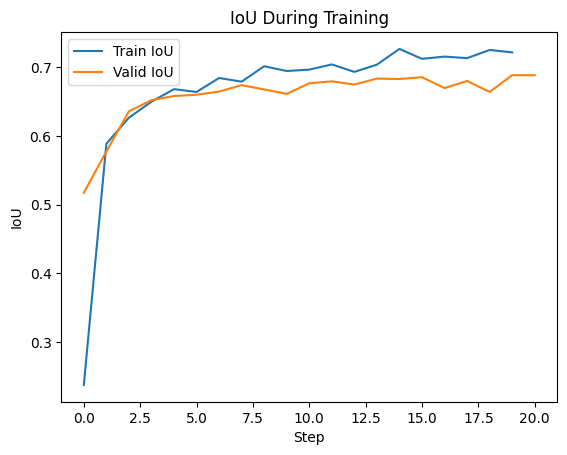

In [19]:
if 'train_dataset_iou' in log_df.columns and 'valid_dataset_iou' in log_df.columns:
    plt.plot(log_df['epoch'], log_df['train_dataset_iou'], label='Train IoU')
    plt.plot(log_df['epoch'], log_df['valid_dataset_iou'], label='Valid IoU')
    plt.xlabel('Step')
    plt.ylabel('IoU')
    plt.title('IoU During Training')
    plt.legend()
    plt.show()